In [35]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

In [10]:
data={
    'no surfacing':[1,1,1,0,0],
    'flippers':[1,1,0,1,1],
    'fish':['yes','yes','no','no','no']
}
df = pd.DataFrame(data)
df

,no surfacing,flippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [11]:
df.iloc[:,-1]

0    yes
1    yes
2     no
3     no
4     no
Name: fish, dtype: object

In [12]:
def calEnt(df):
    # 计算每一个标签的概率
    p_v = df.iloc[:,-1].value_counts(True)
    return -(np.log2(p_v)*p_v).sum()

In [13]:
calEnt(df)

0.9709505944546686

In [14]:
df.columns[:-1]

Index(['no surfacing', 'flippers'], dtype='object')

In [15]:
df["no surfacing"] == 1

0     True
1     True
2     True
3    False
4    False
Name: no surfacing, dtype: bool

In [16]:
def bestSplit(df):

    baseEnt = calEnt(df)
    colName = ''

    infoGain = 0
    bestGain = 0
    for col in df.columns[:-1]:
        p_v = df[col].value_counts(True)
        ent_v = []
        # 此特征的所有取值，循环计算熵
        for value in p_v.index:
            # col 在 不同取值下的熵
            ent_v.append(calEnt(df[df[col] == value]))
        infoGain = baseEnt - (ent_v * p_v).sum()
        if(infoGain > bestGain):
            bestGain = infoGain
            colName = col
    return colName


In [17]:

bestSplit(df)

'no surfacing'

In [18]:
def mySplit(df,col,value):
    return df[df[col]==value].drop(col,axis = 1)

In [19]:
mySplit(df,'no surfacing',0)

,flippers,fish
3,1,no
4,1,no


In [20]:
def createTree(df):

    # 获取特征列 List
    labelFreq = df.iloc[:, -1].value_counts(True)

    # 截至条件：label 只剩一种取值 or df 只剩下一列数据
    if labelFreq[0] == 1 or df.shape[0] == 1:
        return labelFreq.index[0]

    # 最优划分特征
    bestCol = bestSplit(df)
    valueSet = set(df[bestCol])
    # 根据最优划分特征，建立子树
    tree = {bestCol:{}}
    for value in valueSet:
        # 删除已用特征值 和 列，递归调用
        tree[bestCol][value] = createTree(mySplit(df,bestCol,value))
    return tree
    


In [21]:
createTree(df)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [22]:
myTree = createTree(df)

In [23]:
np.save('my.npy',myTree)

In [24]:
np.load('my.npy',allow_pickle=True).item()

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [25]:
myTree = np.load('my.npy',allow_pickle=True).item()
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [26]:
df.columns[:-1]

Index(['no surfacing', 'flippers'], dtype='object')

In [27]:
inX = {
    'no surfacing':0,
    'flippers':1

}

In [28]:
myTree['no surfacing'][1].keys()

dict_keys(['flippers'])

In [29]:
dict(zip(df.columns[:-1],[0,1]))

{'no surfacing': 0, 'flippers': 1}

In [30]:
def getValueFromTree(inX,Tree):
    colName = next(iter(Tree))
    colVal = inX[colName]
    # 取出对应特征列的值 的 子树
    return Tree[colName][colVal]

In [31]:
type(myTree)

dict

In [32]:
def classify(inX,Tree):
# 为 value 增加 key （特征值的colname)
    inX = dict(zip(df.columns[:-1],inX))

# 遍历子树，直到 叶子节点 （即：非dict变量）
    label = getValueFromTree(inX,Tree)
    while type(label) == dict:
        # 遍历下一层树
        label = getValueFromTree(inX,label)
    return label

In [33]:
classify([0,1],myTree)

'no'

In [43]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = tree.createTree(lenses,lensesLabels)


AttributeError: module 'sklearn.tree' has no attribute 'createTree'

In [37]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

[Text(0.4, 0.8333333333333334, 'X[0] <= 0.5\nentropy = 0.971\nsamples = 5\nvalue = [3, 2]'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.6, 0.5, 'X[1] <= 0.5\nentropy = 0.918\nsamples = 3\nvalue = [1, 2]'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]')]

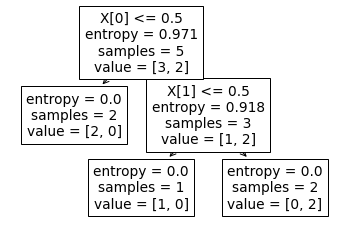

In [42]:
clf = DecisionTreeClassifier(criterion="entropy")
x_train = np.array(df.iloc[:, :-1])
y_train = np.array(df.iloc[:, -1])
clf = clf.fit(x_train,y_train)
plot_tree(clf)